In [ ]:
#Load packages#
import tempfile
import scanpy as sc
import pandas as pd
import os
import numpy as np
import h5py

#read in raw data from mathbiou folder
adata = sc.read_h5ad('/content/drive/MyDrive/Data_for_RNASEQ/3_4_e9_e10.h5ad')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
barcodes = pd.read_csv('/content/drive/MyDrive/Data_for_RNASEQ/Parth/integrated_neuronal.csv')
barcodes = barcodes.Barcode
adata = adata[adata.obs['barcode'].isin(barcodes)]

In [ ]:
import numpy as np
import scanpy as sc

sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata


sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    #Ensure the n_top_genes (HVG's) are set to an appropriate value for desired datasets, i.e. the complexity of celltypes/data
    n_top_genes=4250,
    layer="counts",
    batch_key="batch_key",
    subset=False,
    span = 1
)

In [ ]:
#Remove reporter/uninformative genes from highly variable genes if applicable
genes_to_remove = ['eGFP','tdTomato']
adata.var['highly_variable'] = ~adata.var.index.isin(genes_to_remove) & adata.var['highly_variable']
#Save adata prior to subsetting to HvG's
adata.write('/content/drive/MyDrive/Data_for_RNASEQ/Parth/3_4_pseudotime_integrated.h5ad')
#Subset to HvG's
adata = adata[:, adata.var.highly_variable]

#Here we save the newly formatted merged data before integration so we can use it for other integration methods
adata.write('/content/drive/MyDrive/Data_for_RNASEQ/Parth/3_4_pseudotime_hvg.h5ad')

Reading data
encoder input shape  Tensor("concat:0", shape=(?, 4253), dtype=float32)
decoder input shape  Tensor("concat_2:0", shape=(?, 15), dtype=float32)
KL gaussian z Tensor("mul_10:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_9:0", shape=(?,), dtype=float32)
scDREAMER on DataSet /content/drive/MyDrive/Data_for_RNASEQ/Parth/3_4_pseudotime_hvg.h5ad ... 
Epoch : [0] ,  a_loss = 1441.6703
Epoch : [10] ,  a_loss = 731.9452
Epoch : [20] ,  a_loss = 711.5106
Epoch : [30] ,  a_loss = 697.6856
Epoch : [40] ,  a_loss = 686.6342
Epoch : [50] ,  a_loss = 675.6343
Epoch : [60] ,  a_loss = 667.5214
Epoch : [70] ,  a_loss = 658.8920
Epoch : [80] ,  a_loss = 651.2981
Epoch : [90] ,  a_loss = 644.4056
Epoch : [100] ,  a_loss = 638.1093
Epoch : [110] ,  a_loss = 631.9449
Epoch : [120] ,  a_loss = 626.5809
Epoch : [130] ,  a_loss = 621.3550
Epoch : [140] ,  a_loss = 616.7737
Epoch : [150] ,  a_loss = 612.2440
Epoch : [160] ,  a_loss = 608.1405
Epoch : [170] ,  a_loss = 604.0628
Epoch : [

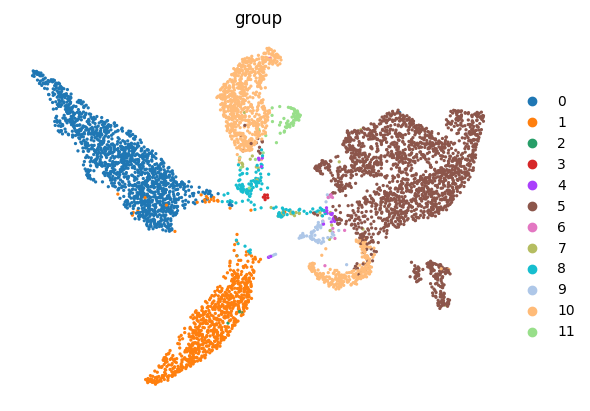

None


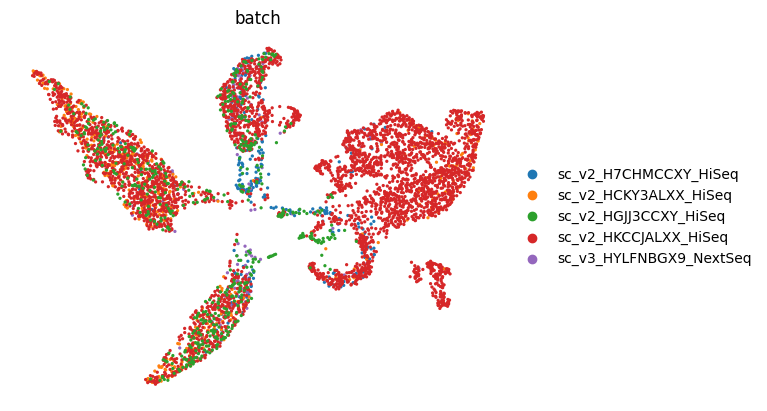

None


In [ ]:
#load packages
import warnings
warnings.filterwarnings('ignore')

import os
import scanpy as sc
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Specify name of the datset to run
path = "/content/drive/MyDrive/Data_for_RNASEQ/Parth/3_4_pseudotime_hvg.h5ad"
name = "3_4_pseudotime_hvg"

data_path = {
    "3_4_pseudotime_hvg": path,
}

batch_key_dict = {
    "3_4_pseudotime_hvg": "batch_key",
}
cell_type_key_dict = {
    "3_4_pseudotime_hvg": "celltype",
}

# Leaning rate to use for small data vs large input data
learning_rate = {
    "3_4_pseudotime_hvg": {"lr_ae" : 0.0002, "lr_dis": 0.0007},
}

#scDREAMER
from scDREAMER import scDREAMER
tf.reset_default_graph()

run_config = tf.ConfigProto()


with tf.Session(config=run_config) as sess:

    dreamer = scDREAMER(
        sess,
	      epoch= 230,
        dataset_name=data_path[name],
        batch=batch_key_dict[name],
        cell_type=cell_type_key_dict[name],
        name=name,
        lr_ae=learning_rate[name]["lr_ae"],
        lr_dis=learning_rate[name]["lr_dis"],
        X_dim = 4248
      )
    dreamer.sess = sess
    dreamer.train_cluster()

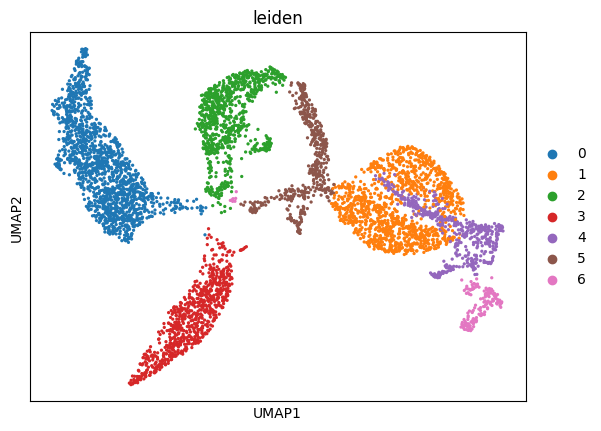

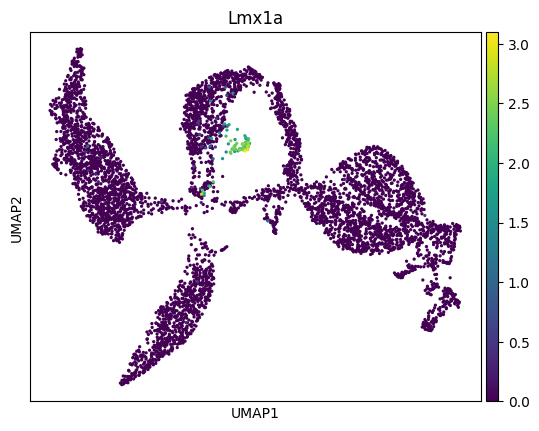

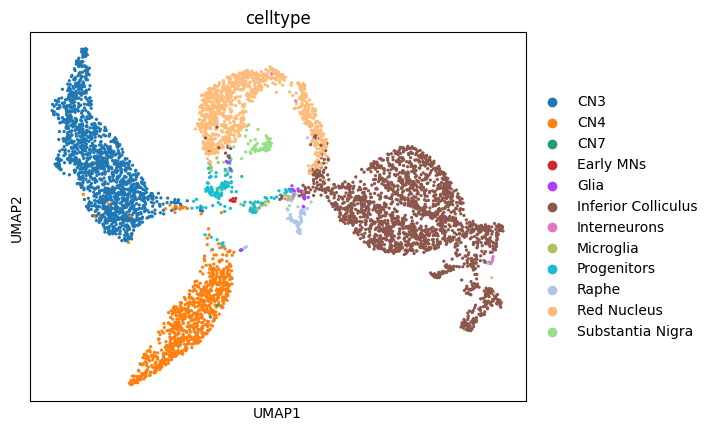

In [ ]:
sc.pl.umap(adata, color="leiden")
sc.pl.umap(adata, color="Lmx1a")
sc.pl.umap(adata, color="celltype")

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 5432 × 40
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'celltype', 'barcode', 'age', 'technology', 'sample_type', 'batch_key', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'Flowcell', 'Sequencing', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [ ]:
import scanpy as sc
import pandas as pd

#Load dataset prior to subsetting to HvGs
adata = sc.read_h5ad('/content/drive/MyDrive/Data_for_RNASEQ/Parth/3_4_pseudotime_integrated.h5ad')

#Load latent matrix created from scDREAMER
latent_matrix = pd.read_csv("/content/3_4_pseudotime_hvglatent_matrix_230.csv", header=None)
adata.obsm['X_latent'] = latent_matrix.values
sc.pp.neighbors(adata, use_rep = 'X_latent')
sc.tl.umap(adata)  # Assuming 'X_latent' is the key you used to store the latent space
sc.tl.leiden(adata, resolution = .2)

#Save fully integrated dataset
adata.write('/content/drive/MyDrive/Data_for_RNASEQ/Parth/integrated_mathexplr.h5ad')

In [ ]:
adata = sc.read_h5ad('/content/drive/MyDrive/Data_for_RNASEQ/Parth/integrated_mathexplr.h5ad')

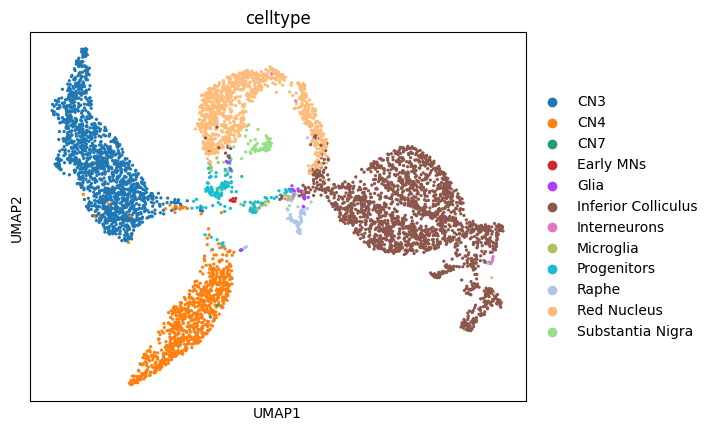

In [ ]:
sc.pl.umap(adata, color="celltype")

In [ ]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import cellrank as cr
import scanpy as sc

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [ ]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [ ]:
import scanpy as sc

adata = sc.read_h5ad('/content/drive/MyDrive/Data_for_RNASEQ/Parth/integrated_mathexplr_subset250FULL.h5ad')
adata

AnnData object with n_obs × n_vars = 5432 × 28390
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'celltype', 'barcode', 'age', 'technology', 'sample_type', 'batch_key', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'Flowcell', 'Sequencing', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
from moscot.problems.time import TemporalProblem

import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

AttributeError: module 'ott.geometry.costs' has no attribute 'ElasticL1'

In [ ]:
!source my_env/bin/activate


/bin/bash: line 1: my_env/bin/activate: No such file or directory


In [ ]:
!python -m venv my_env
!source my_env/bin/activate
!pip install moscot ott-jax scanpy cellrank

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/my_env/bin/python3

/bin/bash: line 1: my_env/bin/activate: No such file or directory
